In [18]:
import os
import sys
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from python.data import Dataloader
from python.models import RandomExampleModel
import python.metrics as metrics
from python.models import HeuristicModel, TwoClustersMIP

In [26]:
import gurobipy
gurobipy.Model()

<gurobi.Model Continuous instance Unnamed: 0 constrs, 0 vars, Parameter changes: LicenseID=2473476>

In [27]:
# Loading the data
data_loader = Dataloader("data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()
Z = data_loader.get_ground_truth_labels()
len(X)

40002

In [28]:
# Let's train an example model
model = HeuristicModel(n_clusters=3,n_pieces=5,n_criteria=10)
# Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

c:\Users\Lenovo Thinkpad T14\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2473476 - for non-commercial use only - registered to ib___@student-cs.fr
Optimize a model with 4061 rows, 10060 columns and 77758 nonzeros
Model fingerprint: 0x07a826b8
Variable types: 8060 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-04, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 197.5051646
Presolve removed 2020 rows and 8010 columns
Presolve time: 0.06s
Presolved: 2041 rows, 2050 columns, 60564 nonzeros
Variable types: 2050 continuous, 0 integer (0 binary)

Root relaxation: objective 1.150513e+00, 221 iterations, 0.07 seconds (0.07 work units)

    Nodes    |    Current Node    |     Ob

In [29]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.07526769863937122 0.04030875565032782 -0.17709128046438727]
 [0.1187958549659438 -0.12092309969698894 -0.007898223484618605]
 [-0.02561818803971949 -0.437430670852536 0.1055081604103052]
 [-0.037947592775836925 0.19141750060678053 0.40645891380435845]
 [0.05833584578321671 0.03824007520587458 -0.16185063216639073]]


In [30]:
data_loader = Dataloader("data/dataset_10")  # Path to test dataset
X, Y = data_loader.load()

np.random.seed(123)
indexes = np.linspace(0, len(X) - 1, num=len(X), dtype=int)
np.random.shuffle(indexes)
train_indexes = indexes[: int(len(indexes) * 0.8)]
test_indexes = indexes[int(len(indexes) * 0.8) :]

X_train = X[train_indexes]
Y_train = Y[train_indexes]
model = HeuristicModel(n_clusters=3,n_pieces=5,n_criteria=10)
model.fit(X_train, Y_train)

X_test = X[test_indexes]
Y_test = Y[test_indexes]
Z_test = data_loader.get_ground_truth_labels()[test_indexes]

c:\Users\Lenovo Thinkpad T14\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2473476 - for non-commercial use only - registered to ib___@student-cs.fr
Optimize a model with 4061 rows, 10060 columns and 77776 nonzeros
Model fingerprint: 0x02283639
Variable types: 8060 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [2e-05, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 63.3439445
Presolve removed 2020 rows and 8010 columns
Presolve time: 0.09s
Presolved: 2041 rows, 2050 columns, 60538 nonzeros
Variable types: 2050 continuous, 0 integer (0 binary)

Root relaxation: objective 9.359135e-01, 255 iterations, 0.08 seconds (0.08 work units)

    Nodes    |    Current Node    |     Obj

In [31]:
print((model.predict_utility(X_test) - model.predict_utility(Y_test))[:5])

[[-0.14087937 -0.02918575  0.16673505]
 [ 0.24367691 -0.02832145  0.04416482]
 [ 0.1322617   0.07279833  0.24238269]
 [-0.343418   -0.03995065 -0.05503977]
 [ 0.31070695  0.21318588  0.2863375 ]]


In [32]:
print(model.predict_preference(X_test, Y_test)[:5])

[[0 0 1]
 [1 0 1]
 [1 1 1]
 [0 0 0]
 [1 1 1]]


In [33]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X_test, Y_test)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.6


In [34]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X_test, Y_test))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X_test), model.predict_utility(Y_test)))

Percentage of explained preferences for all samples: 0.979002624671916
Percentage of explained preferences for all samples: 0.979002624671916


In [35]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X_test, Y_test)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[2 0 2 1 0]


In [36]:

# We can see how it compares to our model's predictions:
print(Z_test[:5])

[0 2 0 0 0]


In [37]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X_test, Y_test)[:5], Z_test[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X_test, Y_test), Z_test))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X_test, Y_test, Z_test))

Cluster intersection for 5 first samples: 0.4
Cluster intersection for all samples: 0.8441599487564054
Cluster intersection for all samples: 0.8441599487564054


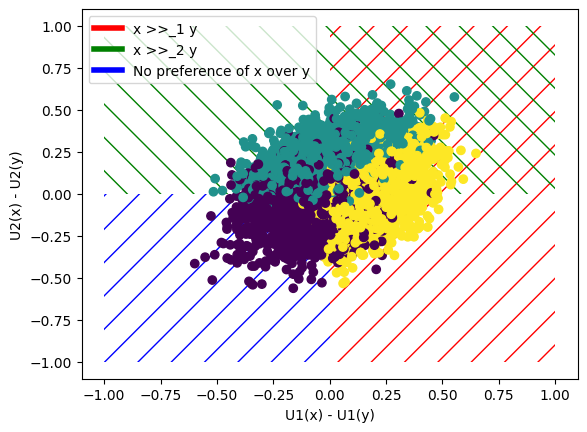

In [38]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X_test)[:, 0]-model.predict_utility(Y_test)[:, 0], 
            model.predict_utility(X_test)[:, 1]-model.predict_utility(Y_test)[:, 1], c=Z_test)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

In [39]:
# This cell should work when you have completed the TwoClustersMIP model
from python.models import TwoClustersMIP

parameters = {"n_pieces": 5, "n_clusters": 2, "n_criteria": 4, "n_pairs": 2000} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)

# Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2473476 - for non-commercial use only - registered to ib___@student-cs.fr
Optimize a model with 6050 rows, 12048 columns and 76714 nonzeros
Model fingerprint: 0x3279e99c
Variable types: 8048 continuous, 4000 integer (4000 binary)
Coefficient statistics:
  Matrix range     [3e-05, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 173.0309482
Presolve removed 2016 rows and 8008 columns
Presolve time: 0.12s
Presolved: 4034 rows, 4040 columns, 54836 nonzeros
Variable types: 2040 continuous, 2000 integer (2000 binary)

Root relaxation: objective 0.000000e+00, 2916 iterations, 0.38 seconds (0.65 work units)

    Nodes    |    Current Node    |

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Lenovo Thinkpad T14\AppData\Roaming\Python\Python310\site-packages\ipykernel\iostream.py", line 624, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


 593183 477636    6.51245   62  271    9.39400    0.77636  91.7%   262 3921s
 593596 478591    3.40083   45  492    9.39400    0.77636  91.7%   262 3927s
 594691 479322    6.59058   70  402    9.39400    0.77704  91.7%   262 3934s
 595601 480365    1.18293   43  350    9.39400    0.77755  91.7%   262 3941s
 596789 481526    2.87364   47  482    9.39400    0.77767  91.7%   262 3947s
 598141 482846    4.11941   74  334    9.39400    0.77826  91.7%   262 3954s
 599693 483611    2.67470   49  392    9.39400    0.77886  91.7%   262 3959s
 600542 484117    9.32878   94  266    9.39400    0.77886  91.7%   262 3963s
 601229 484640    5.11226   50  495    9.39400    0.77886  91.7%   262 3967s
 601949 485462    5.56601   56  484    9.39400    0.77886  91.7%   262 3971s
 602991 486240    5.49768   60  277    9.39400    0.77905  91.7%   262 3978s
 604104 486855    6.62806   65  313    9.39400    0.78041  91.7%   262 3983s
 604970 487516    3.90374   56  357    9.39400    0.78068  91.7%   262 3988s

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Lenovo Thinkpad T14\AppData\Roaming\Python\Python310\site-packages\ipykernel\iostream.py", line 624, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


 621297 501182    8.10246   73  423    9.39400    0.78551  91.6%   262 4087s
 622410 501191    3.71920   51  282    9.39400    0.78553  91.6%   262 4100s
 622421 502242    3.86939   52  281    9.39400    0.78610  91.6%   262 4107s
 623659 503002    7.15404   73  358    9.39400    0.78671  91.6%   262 4113s
 624634 503936    3.33675   48  367    9.39400    0.78753  91.6%   262 4121s
 625803 504987    1.90858   40  505    9.39400    0.78772  91.6%   262 4127s
 626993 505795    7.64054   85  293    9.39400    0.78780  91.6%   262 4133s
 628058 506298    3.88029   46  284    9.39400    0.78784  91.6%   262 4138s
 628717 506995    7.03739   63  370    9.39400    0.78867  91.6%   262 4145s
 629622 508190    4.41139   53  486    9.39400    0.78943  91.6%   262 4151s
 631019 508932    5.43873   61  369    9.39400    0.79003  91.6%   262 4156s
 631971 509586    2.50889   45  423    9.39400    0.79006  91.6%   262 4163s
 632814 510772    3.32845   46  420    9.39400    0.79006  91.6%   262 4170s

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Lenovo Thinkpad T14\AppData\Roaming\Python\Python310\site-packages\ipykernel\iostream.py", line 624, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


 730186 589460    8.27413   75  360    9.39400    0.82200  91.2%   263 4773s


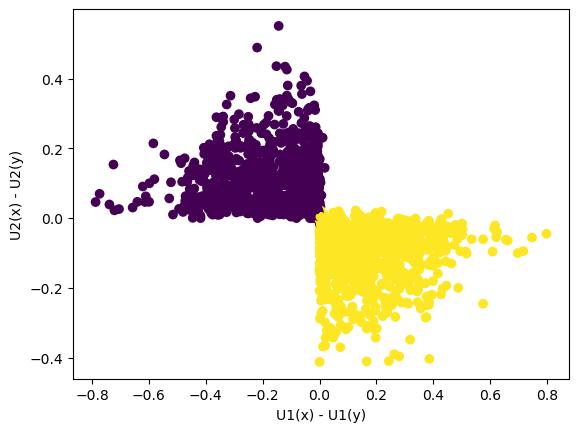

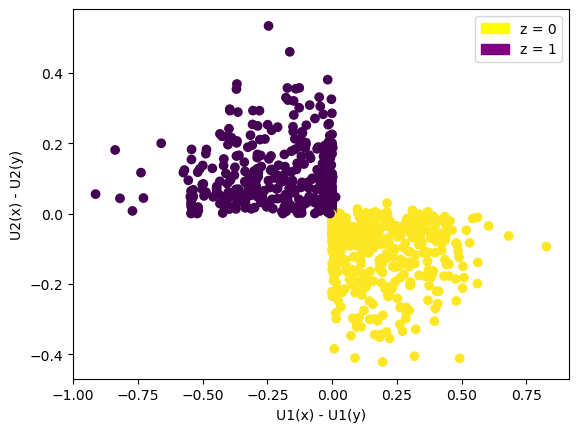

In [ ]:
# As an example here are the results obtained with:
# Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()

# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")